# 🎯 Notebook 06: Linear Discriminant Analysis (LDA)
## Intelligent Agriculture - Crop Recommendation System

**Objectives:**
1. Implement LDA for dimensionality reduction
2. Compare LDA vs PCA for classification
3. Analyze class separability
4. Visualize discriminant functions
5. Feature importance in discriminant space

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load preprocessed data
train_data = pd.read_csv('../data/processed/train.csv')
val_data = pd.read_csv('../data/processed/validation.csv')
test_data = pd.read_csv('../data/processed/test.csv')
scaler = joblib.load('../data/processed/scaler.pkl')  # FIX: Load scaler
label_encoder = joblib.load('../data/processed/label_encoder.pkl')

print(f"✅ Data loaded: {len(train_data)} train, {len(val_data)} val, {len(test_data)} test")

# Prepare features and targets
feature_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X_train = train_data[feature_cols]
X_val = val_data[feature_cols]
X_test = test_data[feature_cols]
y_train = train_data['label']
y_val = val_data['label']
y_test = test_data['label']

# Scale features (important for LDA)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

target_names = label_encoder.classes_
n_classes = len(target_names)
n_features = len(feature_cols)

print(f"Number of features: {n_features}")
print(f"Number of classes: {n_classes}")
print(f"Maximum LDA components: {min(n_features, n_classes-1)}")

✅ Data loaded: 1540 train, 330 val, 330 test
Number of features: 7
Number of classes: 22
Maximum LDA components: 7


In [3]:
# Implement LDA with maximum components
print("🎯 LINEAR DISCRIMINANT ANALYSIS")
print("=" * 50)

# LDA can have at most min(n_features, n_classes-1) components
max_components = min(n_features, n_classes - 1)
print(f"Maximum LDA components: {max_components}")

# Fit LDA with all possible components
lda_full = LinearDiscriminantAnalysis()
X_train_lda_full = lda_full.fit_transform(X_train_scaled, y_train)  # FIX: Use scaled data
X_val_lda_full = lda_full.transform(X_val_scaled)  # FIX: Use scaled data
X_test_lda_full = lda_full.transform(X_test_scaled)  # FIX: Use scaled data

print(f"LDA transformed shape: {X_train_lda_full.shape}")
print(f"Actual LDA components: {X_train_lda_full.shape[1]}")

# Explained variance ratio for LDA
explained_variance_ratio_lda = lda_full.explained_variance_ratio_
cumulative_variance_ratio_lda = np.cumsum(explained_variance_ratio_lda)

print("\nLDA Explained Variance Ratio by Component:")
for i, ratio in enumerate(explained_variance_ratio_lda):
    print(f"LD{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

print("\nLDA Cumulative Explained Variance:")
for i, cum_ratio in enumerate(cumulative_variance_ratio_lda):
    print(f"LD1-LD{i+1}: {cum_ratio:.4f} ({cum_ratio*100:.2f}%)")

🎯 LINEAR DISCRIMINANT ANALYSIS
Maximum LDA components: 7
LDA transformed shape: (1540, 7)
Actual LDA components: 7

LDA Explained Variance Ratio by Component:
LD1: 0.8440 (84.40%)
LD2: 0.0931 (9.31%)
LD3: 0.0244 (2.44%)
LD4: 0.0182 (1.82%)
LD5: 0.0165 (1.65%)
LD6: 0.0025 (0.25%)
LD7: 0.0013 (0.13%)

LDA Cumulative Explained Variance:
LD1-LD1: 0.8440 (84.40%)
LD1-LD2: 0.9371 (93.71%)
LD1-LD3: 0.9615 (96.15%)
LD1-LD4: 0.9797 (97.97%)
LD1-LD5: 0.9962 (99.62%)
LD1-LD6: 0.9987 (99.87%)
LD1-LD7: 1.0000 (100.00%)


In [4]:
# Compare LDA with PCA
print("\n📊 LDA vs PCA COMPARISON")
print("=" * 50)

# Fit PCA for comparison
pca_comp = PCA(n_components=max_components)
X_train_pca_comp = pca_comp.fit_transform(X_train)
X_val_pca_comp = pca_comp.transform(X_val)
X_test_pca_comp = pca_comp.transform(X_test)

explained_variance_ratio_pca = pca_comp.explained_variance_ratio_
cumulative_variance_ratio_pca = np.cumsum(explained_variance_ratio_pca)

print("Comparison of explained variance:")
comparison_df = pd.DataFrame({
    'Component': [f'Component {i+1}' for i in range(max_components)],
    'LDA_Variance': explained_variance_ratio_lda,
    'PCA_Variance': explained_variance_ratio_pca,
    'LDA_Cumulative': cumulative_variance_ratio_lda,
    'PCA_Cumulative': cumulative_variance_ratio_pca
})
print(comparison_df)


📊 LDA vs PCA COMPARISON
Comparison of explained variance:
     Component  LDA_Variance  PCA_Variance  LDA_Cumulative  PCA_Cumulative
0  Component 1      0.844029      0.401320        0.844029        0.401320
1  Component 2      0.093106      0.343656        0.937135        0.744976
2  Component 3      0.024356      0.157773        0.961491        0.902749
3  Component 4      0.018205      0.064997        0.979696        0.967746
4  Component 5      0.016489      0.029497        0.996186        0.997243
5  Component 6      0.002536      0.002691        0.998721        0.999933
6  Component 7      0.001279      0.000067        1.000000        1.000000


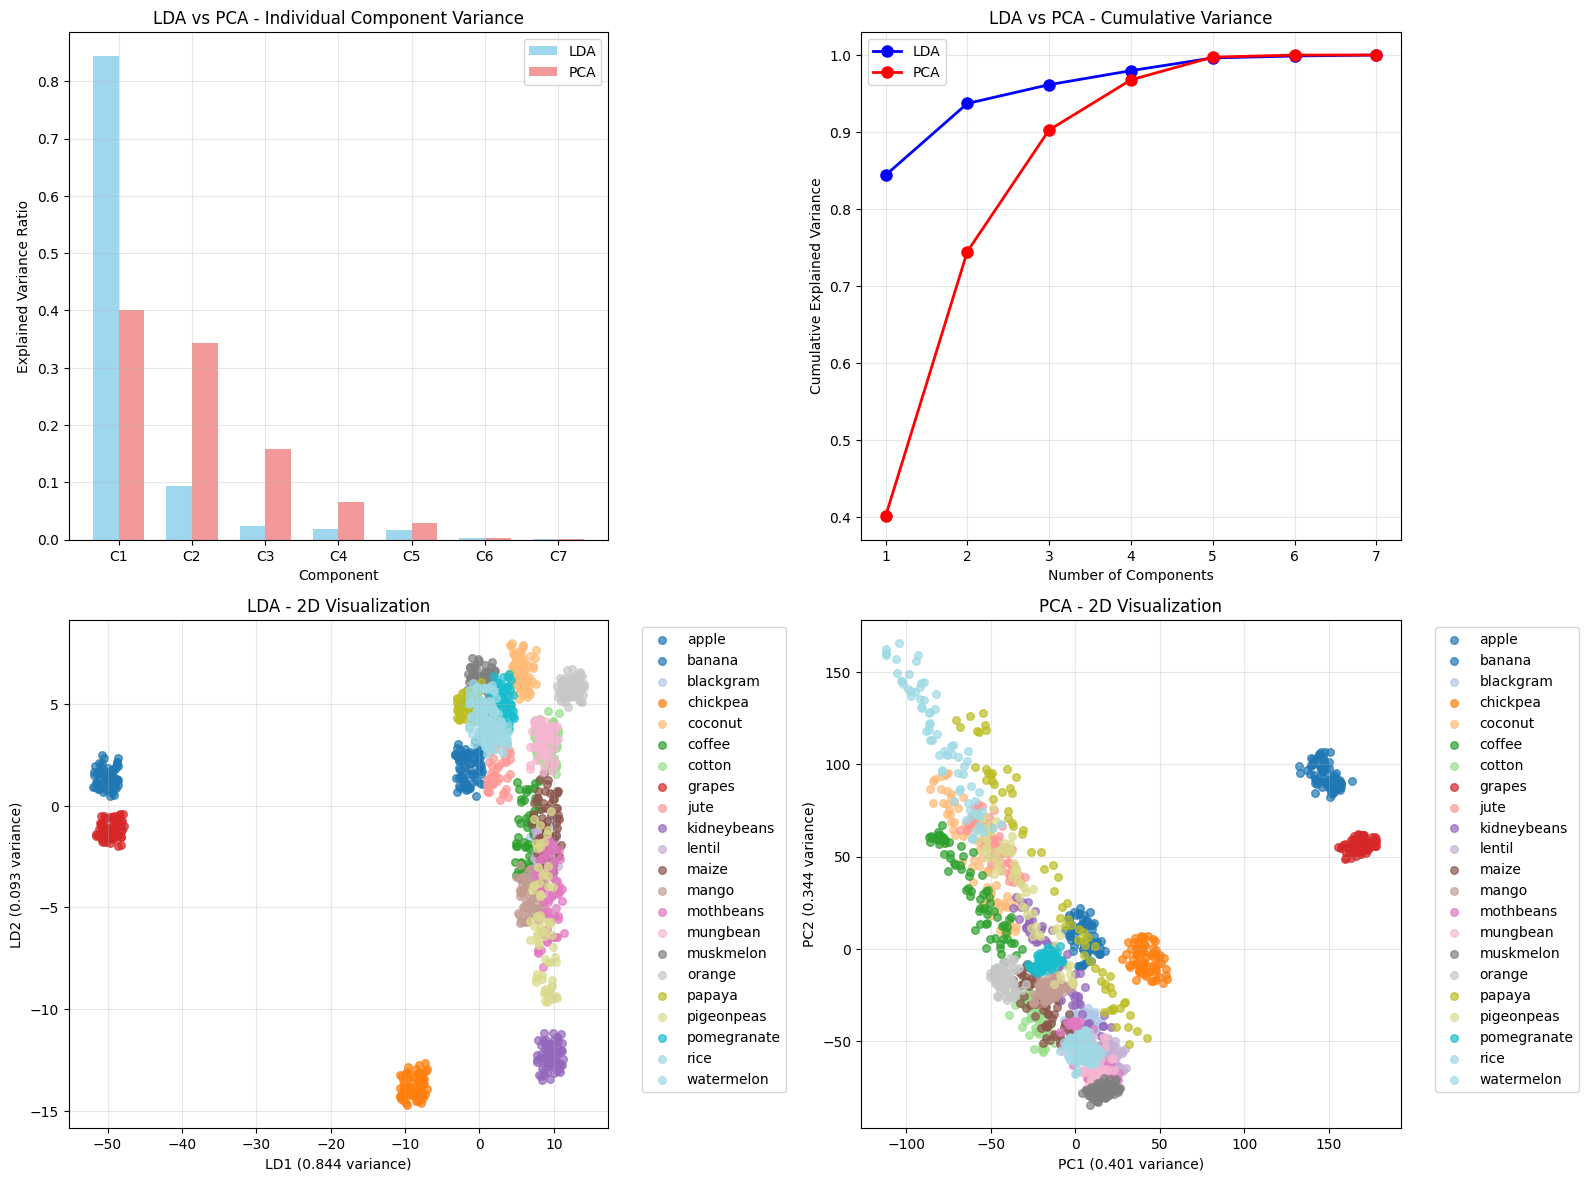

In [5]:
# Visualize LDA vs PCA explained variance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Individual explained variance comparison
x_pos = np.arange(max_components)
width = 0.35

axes[0, 0].bar(x_pos - width/2, explained_variance_ratio_lda, width, 
              label='LDA', alpha=0.8, color='skyblue')
axes[0, 0].bar(x_pos + width/2, explained_variance_ratio_pca, width, 
              label='PCA', alpha=0.8, color='lightcoral')
axes[0, 0].set_xlabel('Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title('LDA vs PCA - Individual Component Variance')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([f'C{i+1}' for i in range(max_components)])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Cumulative explained variance comparison
axes[0, 1].plot(range(1, max_components + 1), cumulative_variance_ratio_lda, 
               'bo-', linewidth=2, markersize=8, label='LDA')
axes[0, 1].plot(range(1, max_components + 1), cumulative_variance_ratio_pca, 
               'ro-', linewidth=2, markersize=8, label='PCA')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance')
axes[0, 1].set_title('LDA vs PCA - Cumulative Variance')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, max_components + 1))

# LDA 2D visualization
if X_train_lda_full.shape[1] >= 2:
    unique_classes = np.unique(y_train)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
    
    for i, class_label in enumerate(unique_classes):
        mask = y_train == class_label
        axes[1, 0].scatter(X_train_lda_full[mask, 0], X_train_lda_full[mask, 1], 
                          c=[colors[i]], label=target_names[class_label], alpha=0.7, s=30)
    
    axes[1, 0].set_xlabel(f'LD1 ({explained_variance_ratio_lda[0]:.3f} variance)')
    axes[1, 0].set_ylabel(f'LD2 ({explained_variance_ratio_lda[1]:.3f} variance)')
    axes[1, 0].set_title('LDA - 2D Visualization')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True, alpha=0.3)

# PCA 2D visualization for comparison
if X_train_pca_comp.shape[1] >= 2:
    for i, class_label in enumerate(unique_classes):
        mask = y_train == class_label
        axes[1, 1].scatter(X_train_pca_comp[mask, 0], X_train_pca_comp[mask, 1], 
                          c=[colors[i]], label=target_names[class_label], alpha=0.7, s=30)
    
    axes[1, 1].set_xlabel(f'PC1 ({explained_variance_ratio_pca[0]:.3f} variance)')
    axes[1, 1].set_ylabel(f'PC2 ({explained_variance_ratio_pca[1]:.3f} variance)')
    axes[1, 1].set_title('PCA - 2D Visualization')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# LDA Classification Performance
print("\n🎯 LDA CLASSIFICATION PERFORMANCE")
print("=" * 50)

# Test different numbers of LDA components
lda_results = []
component_range = range(1, min(max_components + 1, 8))  # Test up to 7 components

for n_comp in component_range:
    print(f"\n🔍 Testing LDA with {n_comp} components:")
    
    # Fit LDA with specific number of components
    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    X_train_lda = lda.fit_transform(X_train_scaled, y_train)  # FIX: Use scaled data
    X_val_lda = lda.transform(X_val_scaled)  # FIX: Use scaled data
    
    # Direct LDA classification
    y_val_pred_lda = lda.predict(X_val_scaled)  # FIX: Use scaled data
    accuracy_lda_direct = accuracy_score(y_val, y_val_pred_lda)
    
    # LDA + Logistic Regression
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_lda, y_train)
    y_val_pred_lr = lr.predict(X_val_lda)
    accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
    
    # Calculate explained variance for this number of components
    explained_var = lda.explained_variance_ratio_.sum() if hasattr(lda, 'explained_variance_ratio_') else np.nan
    
    lda_results.append({
        'Components': n_comp,
        'LDA_Direct_Accuracy': accuracy_lda_direct,
        'LDA_LR_Accuracy': accuracy_lr,
        'Explained_Variance': explained_var
    })
    
    print(f"   LDA Direct: {accuracy_lda_direct:.4f}")
    print(f"   LDA + LR: {accuracy_lr:.4f}")
    if not np.isnan(explained_var):
        print(f"   Explained Variance: {explained_var:.4f}")

lda_results_df = pd.DataFrame(lda_results)
print("\n📊 LDA Results Summary:")
print(lda_results_df)


🎯 LDA CLASSIFICATION PERFORMANCE

🔍 Testing LDA with 1 components:
   LDA Direct: 0.9606
   LDA + LR: 0.3121
   Explained Variance: 0.8440

🔍 Testing LDA with 2 components:
   LDA Direct: 0.9606
   LDA + LR: 0.7000
   Explained Variance: 0.9371

🔍 Testing LDA with 3 components:
   LDA Direct: 0.9606
   LDA + LR: 0.8879
   Explained Variance: 0.9615

🔍 Testing LDA with 4 components:
   LDA Direct: 0.9606
   LDA + LR: 0.9667
   Explained Variance: 0.9797

🔍 Testing LDA with 5 components:
   LDA Direct: 0.9606
   LDA + LR: 0.9697
   Explained Variance: 0.9962

🔍 Testing LDA with 6 components:
   LDA Direct: 0.9606
   LDA + LR: 0.9788
   Explained Variance: 0.9987

🔍 Testing LDA with 7 components:
   LDA Direct: 0.9606
   LDA + LR: 0.9818
   Explained Variance: 1.0000

📊 LDA Results Summary:
   Components  LDA_Direct_Accuracy  LDA_LR_Accuracy  Explained_Variance
0           1             0.960606         0.312121            0.844029
1           2             0.960606         0.700000     

In [7]:
# Compare LDA vs PCA classification performance
print("\n⚖️ LDA vs PCA CLASSIFICATION COMPARISON")
print("=" * 50)

# Test PCA with same number of components
pca_results = []

for n_comp in component_range:
    # PCA
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    
    # PCA + Logistic Regression
    lr_pca = LogisticRegression(random_state=42, max_iter=1000)
    lr_pca.fit(X_train_pca, y_train)
    y_val_pred_pca = lr_pca.predict(X_val_pca)
    accuracy_pca = accuracy_score(y_val, y_val_pred_pca)
    
    explained_var_pca = pca.explained_variance_ratio_.sum()
    
    pca_results.append({
        'Components': n_comp,
        'PCA_LR_Accuracy': accuracy_pca,
        'Explained_Variance': explained_var_pca
    })

pca_results_df = pd.DataFrame(pca_results)

# Merge results for comparison
comparison_results = pd.merge(lda_results_df, pca_results_df, on='Components', suffixes=('_LDA', '_PCA'))
print("LDA vs PCA Comparison:")
print(comparison_results[['Components', 'LDA_Direct_Accuracy', 'LDA_LR_Accuracy', 'PCA_LR_Accuracy']])


⚖️ LDA vs PCA CLASSIFICATION COMPARISON
LDA vs PCA Comparison:
   Components  LDA_Direct_Accuracy  LDA_LR_Accuracy  PCA_LR_Accuracy
0           1             0.960606         0.312121         0.351515
1           2             0.960606         0.700000         0.687879
2           3             0.960606         0.887879         0.851515
3           4             0.960606         0.966667         0.957576
4           5             0.960606         0.969697         0.975758
5           6             0.960606         0.978788         0.990909
6           7             0.960606         0.981818         0.990909


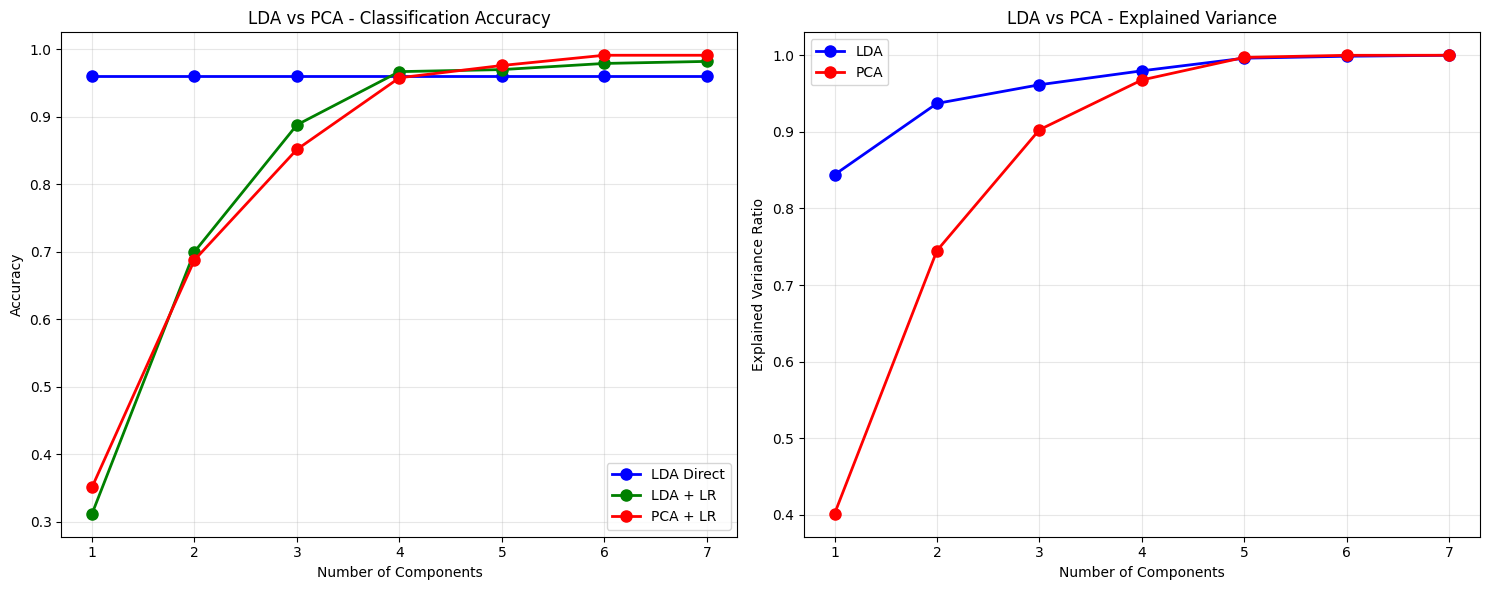

In [8]:
# Visualize LDA vs PCA performance comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
axes[0].plot(comparison_results['Components'], comparison_results['LDA_Direct_Accuracy'], 
            'bo-', linewidth=2, markersize=8, label='LDA Direct')
axes[0].plot(comparison_results['Components'], comparison_results['LDA_LR_Accuracy'], 
            'go-', linewidth=2, markersize=8, label='LDA + LR')
axes[0].plot(comparison_results['Components'], comparison_results['PCA_LR_Accuracy'], 
            'ro-', linewidth=2, markersize=8, label='PCA + LR')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('LDA vs PCA - Classification Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(comparison_results['Components'])

# Explained variance comparison
axes[1].plot(comparison_results['Components'], comparison_results['Explained_Variance_LDA'], 
            'bo-', linewidth=2, markersize=8, label='LDA')
axes[1].plot(comparison_results['Components'], comparison_results['Explained_Variance_PCA'], 
            'ro-', linewidth=2, markersize=8, label='PCA')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('LDA vs PCA - Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(comparison_results['Components'])

plt.tight_layout()
plt.show()


🔍 FEATURE IMPORTANCE IN LDA SPACE
LDA scalings shape: (7, 7)
Feature Loadings on Linear Discriminants:
                 LD1     LD2     LD3     LD4     LD5
N             0.0901  0.4221 -2.9395 -0.0979  0.8256
P            -0.9064 -0.9301  0.6475 -2.6610  3.0533
K           -15.7551 -0.3180 -1.1550  2.0338 -2.4094
temperature   0.0047  0.0357  0.1015 -0.0253  0.1497
humidity     -0.5572  5.2529  1.1863 -0.5797  0.9346
ph            0.0230 -0.0467 -0.0051  0.0809  0.1056
rainfall     -0.1652  0.1832 -0.4224 -2.0371 -1.5314


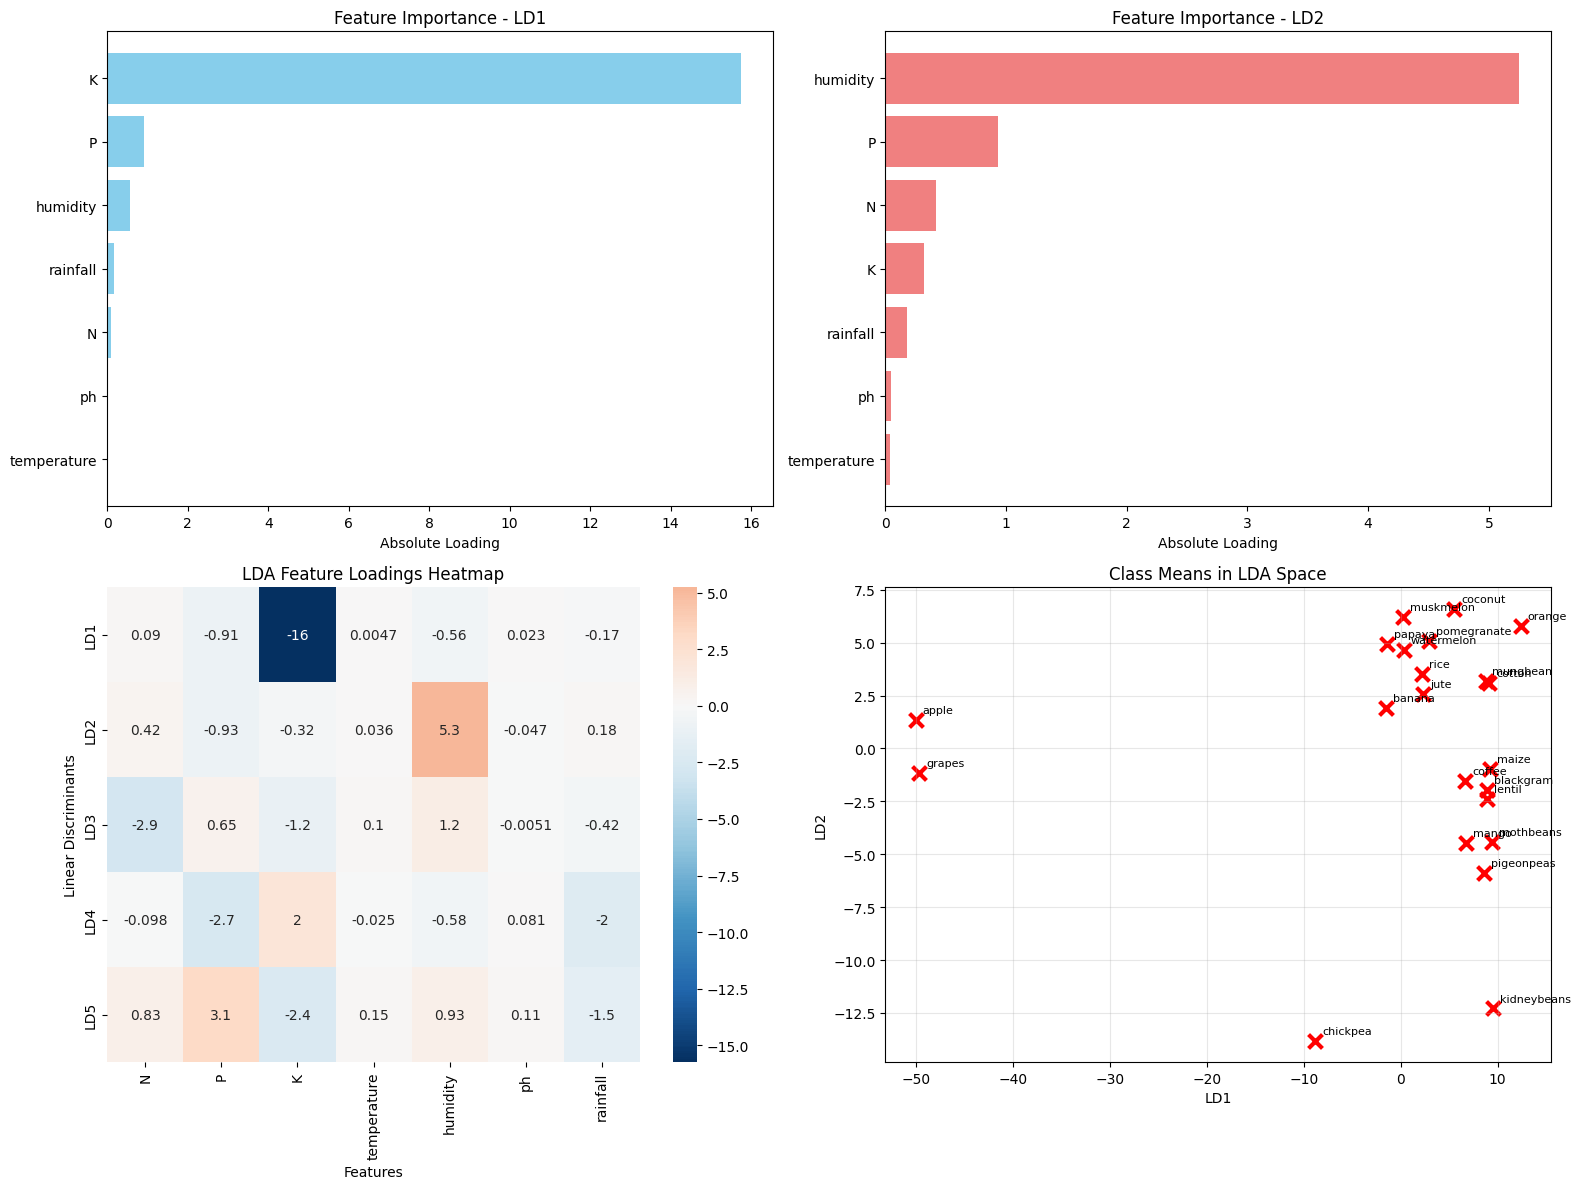

In [9]:
# Feature importance analysis in LDA space
print("\n🔍 FEATURE IMPORTANCE IN LDA SPACE")
print("=" * 50)

# Get LDA scalings (feature loadings)
lda_scalings = lda_full.scalings_
print(f"LDA scalings shape: {lda_scalings.shape}")

# Create feature importance DataFrame
n_components_to_show = min(5, lda_scalings.shape[1])
feature_importance_lda = pd.DataFrame(
    lda_scalings[:, :n_components_to_show],
    columns=[f'LD{i+1}' for i in range(n_components_to_show)],
    index=feature_cols
)

print("Feature Loadings on Linear Discriminants:")
print(feature_importance_lda.round(4))

# Visualize feature importance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# LD1 feature importance
ld1_importance = feature_importance_lda['LD1'].abs().sort_values(ascending=True)
axes[0, 0].barh(ld1_importance.index, ld1_importance.values, color='skyblue')
axes[0, 0].set_title('Feature Importance - LD1')
axes[0, 0].set_xlabel('Absolute Loading')

# LD2 feature importance (if available)
if 'LD2' in feature_importance_lda.columns:
    ld2_importance = feature_importance_lda['LD2'].abs().sort_values(ascending=True)
    axes[0, 1].barh(ld2_importance.index, ld2_importance.values, color='lightcoral')
    axes[0, 1].set_title('Feature Importance - LD2')
    axes[0, 1].set_xlabel('Absolute Loading')

# Heatmap of feature loadings
sns.heatmap(feature_importance_lda.T, annot=True, cmap='RdBu_r', center=0, ax=axes[1, 0])
axes[1, 0].set_title('LDA Feature Loadings Heatmap')
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Linear Discriminants')

# Class means in LDA space
class_means_lda = []
for class_label in range(n_classes):
    mask = y_train == class_label
    if np.any(mask):
        mean_lda = np.mean(X_train_lda_full[mask], axis=0)
        class_means_lda.append(mean_lda)

if len(class_means_lda) > 0 and X_train_lda_full.shape[1] >= 2:
    class_means_array = np.array(class_means_lda)
    axes[1, 1].scatter(class_means_array[:, 0], class_means_array[:, 1], 
                      s=100, c='red', marker='x', linewidths=3)
    
    for i, class_name in enumerate(target_names[:len(class_means_lda)]):
        axes[1, 1].annotate(class_name, 
                           (class_means_array[i, 0], class_means_array[i, 1]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    axes[1, 1].set_xlabel('LD1')
    axes[1, 1].set_ylabel('LD2')
    axes[1, 1].set_title('Class Means in LDA Space')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🎯 FINAL EVALUATION ON TEST SET
Best LDA configuration: 1 components (Accuracy: 0.9606)

🧪 Test Set Results:
LDA Test Accuracy: 0.9697

📋 Detailed Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        15
   blackgram       0.78      0.93      0.85        15
    chickpea       1.00      1.00      1.00        15
     coconut       1.00      0.93      0.97        15
      coffee       1.00      1.00      1.00        15
      cotton       0.94      1.00      0.97        15
      grapes       1.00      1.00      1.00        15
        jute       0.88      1.00      0.94        15
 kidneybeans       1.00      1.00      1.00        15
      lentil       0.92      0.80      0.86        15
       maize       1.00      0.93      0.97        15
       mango       1.00      1.00      1.00        15
   mothbeans       1.00      1.00      1.00        15
    mungbean       

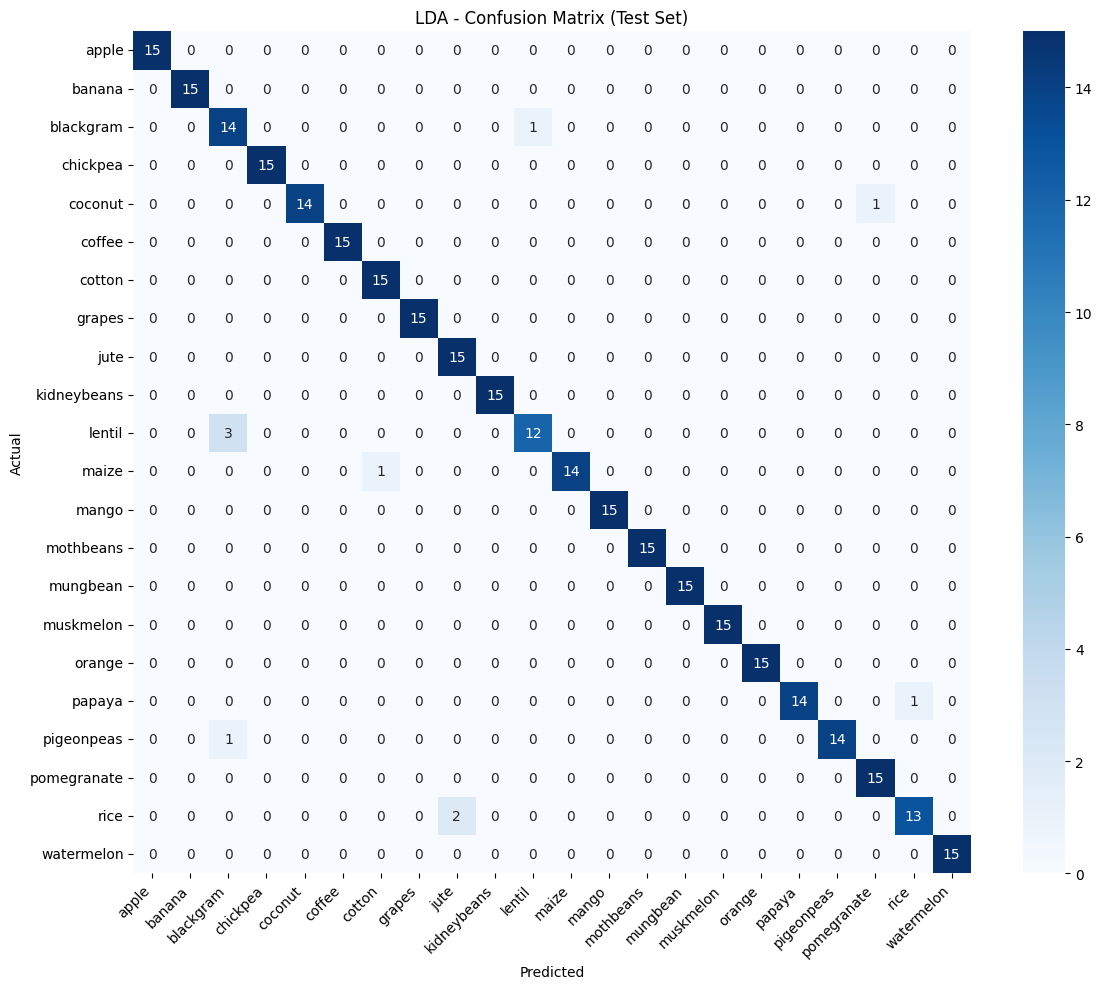

In [10]:
# Final evaluation on test set
print("\n🎯 FINAL EVALUATION ON TEST SET")
print("=" * 50)

# Find best LDA configuration
best_lda_idx = lda_results_df['LDA_Direct_Accuracy'].idxmax()
best_n_components = lda_results_df.loc[best_lda_idx, 'Components']
best_accuracy = lda_results_df.loc[best_lda_idx, 'LDA_Direct_Accuracy']

print(f"Best LDA configuration: {best_n_components} components (Accuracy: {best_accuracy:.4f})")

# Train final LDA model
lda_final = LinearDiscriminantAnalysis(n_components=best_n_components)
lda_final.fit(X_train_scaled, y_train)  # FIX: Use scaled data

# Test set evaluation
y_test_pred_lda = lda_final.predict(X_test_scaled)  # FIX: Use scaled data
test_accuracy_lda = accuracy_score(y_test, y_test_pred_lda)

print(f"\n🧪 Test Set Results:")
print(f"LDA Test Accuracy: {test_accuracy_lda:.4f}")

# Detailed classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_test_pred_lda, target_names=target_names))

# Confusion matrix
cm_lda = confusion_matrix(y_test, y_test_pred_lda)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('LDA - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
# Save LDA results and models
print("\n💾 SAVING LDA RESULTS AND MODELS")
print("=" * 50)

# Save LDA models
joblib.dump(lda_full, '../data/processed/lda_full_model.pkl')
joblib.dump(lda_final, '../data/processed/lda_best_model.pkl')

# Save results
lda_results_df.to_csv('../data/processed/lda_classification_results.csv', index=False)
comparison_results.to_csv('../data/processed/lda_pca_comparison.csv', index=False)
feature_importance_lda.to_csv('../data/processed/lda_feature_importance.csv')

# Save LDA summary
lda_summary = {
    'Best_Components': best_n_components,
    'Best_Validation_Accuracy': best_accuracy,
    'Test_Accuracy': test_accuracy_lda,
    'Max_Possible_Components': max_components,
    'Total_Classes': n_classes,
    'Total_Features': n_features
}

summary_df = pd.DataFrame([lda_summary])
summary_df.to_csv('../data/processed/lda_summary.csv', index=False)

print("✅ LDA models saved to: data/processed/")
print("✅ Classification results saved to: data/processed/lda_classification_results.csv")
print("✅ LDA vs PCA comparison saved to: data/processed/lda_pca_comparison.csv")
print("✅ Feature importance saved to: data/processed/lda_feature_importance.csv")
print("✅ LDA summary saved to: data/processed/lda_summary.csv")

print("\n🎯 KEY INSIGHTS:")
print(f"• Best LDA uses {best_n_components} components with {best_accuracy:.1%} accuracy")
print(f"• LDA achieved {test_accuracy_lda:.1%} test accuracy")
print(f"• LDA is supervised and optimizes class separability")
print(f"• Maximum {max_components} discriminant functions for {n_classes} classes")
print(f"• Most discriminative features: {', '.join(ld1_importance.tail(3).index.tolist())}")

print("\n🚀 Next: Open notebook 07_Ensemble_Methods.ipynb")


💾 SAVING LDA RESULTS AND MODELS
✅ LDA models saved to: data/processed/
✅ Classification results saved to: data/processed/lda_classification_results.csv
✅ LDA vs PCA comparison saved to: data/processed/lda_pca_comparison.csv
✅ Feature importance saved to: data/processed/lda_feature_importance.csv
✅ LDA summary saved to: data/processed/lda_summary.csv

🎯 KEY INSIGHTS:
• Best LDA uses 1 components with 96.1% accuracy
• LDA achieved 97.0% test accuracy
• LDA is supervised and optimizes class separability
• Maximum 7 discriminant functions for 22 classes
• Most discriminative features: humidity, P, K

🚀 Next: Open notebook 07_Ensemble_Methods.ipynb
